# Beispiel Klassifikation handgeschriebener Ziffern des MNIST-Datensatzes — **MLP (Fully Connected)**

Notebook fürs Training eines **fully connected networks (1 verborgene Scnhicht)** auf MNIST-Daten mit Bildern als 1D-Vektoren (28×28 → 784).  

> Angepasst vom offiziellen [PyTorch MNIST Beispiel](https://github.com/pytorch/examples/blob/main/mnist/main.py).


In [ ]:
#@title Install dependencies (Colab usually has these pre-installed)
!pip -q install torch torchvision matplotlib tqdm pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.4 MB/s eta 0:00:00


## Modell definieren

In [1]:
class FCNet(nn.Module):
    def __init__(self, hidden=256, p_drop=0.2):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)
        self.drop = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(hidden, 10)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = FCNet(hidden=cfg.hidden, p_drop=cfg.p_drop).to(device)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"Trainable parameters: {n_params:,}")

NameError: name 'nn' is not defined

Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.2MB/s]


Train: 50000 | Val: 10000 | Test: 10000
FCNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Trainable parameters: 203,530


/tmp/ipython-input-3670635426.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp and device.type == "cuda")


Train Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

/tmp/ipython-input-3670635426.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


Train avg loss: 0.2690
Val: avg loss 0.1474, acc 95.61% (9561/10000)
✅ Saved new best MLP (val acc=95.61%)


Train Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Train avg loss: 0.1272
Val: avg loss 0.1242, acc 96.26% (9626/10000)
✅ Saved new best MLP (val acc=96.26%)


Train Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Train avg loss: 0.0852
Val: avg loss 0.0906, acc 97.24% (9724/10000)
✅ Saved new best MLP (val acc=97.24%)


Train Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Train avg loss: 0.0678
Val: avg loss 0.0890, acc 97.31% (9731/10000)
✅ Saved new best MLP (val acc=97.31%)


Train Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Train avg loss: 0.0505
Val: avg loss 0.0781, acc 97.58% (9758/10000)
✅ Saved new best MLP (val acc=97.58%)
Best validation accuracy: 97.58%


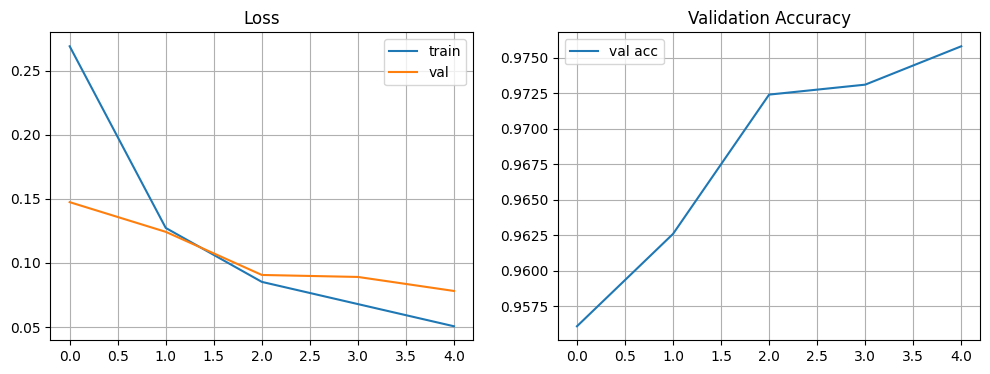

Test: avg loss 0.0667, acc 97.92% (9792/10000)


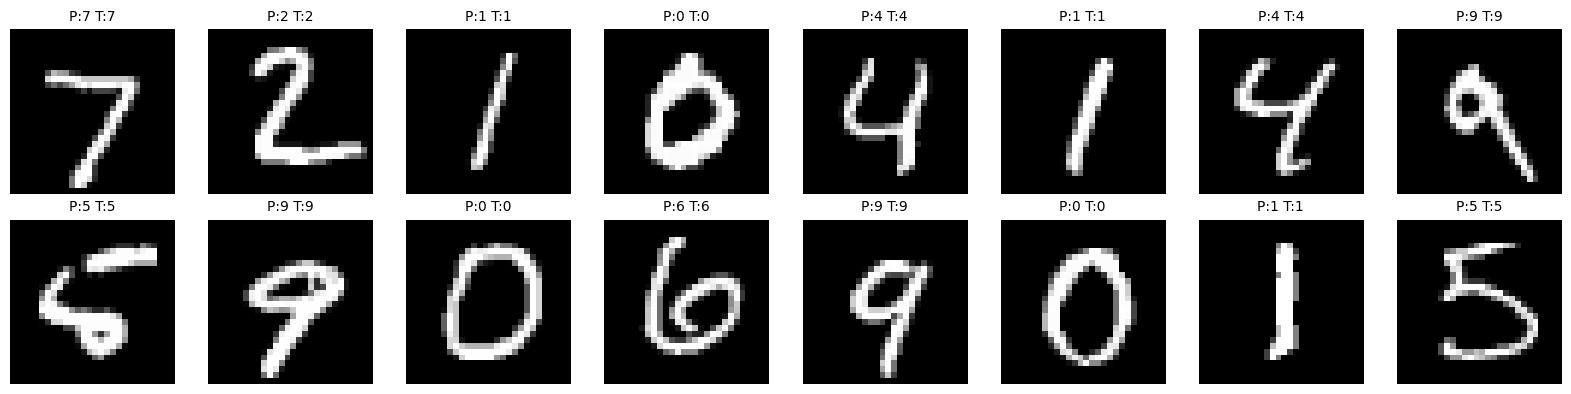

In [ ]:
#@title MNIST: data, MLP model, training with validation, test, and visualization
import os, math, random, io
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

@dataclass
class Config:
    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 5
    lr: float = 1e-3
    gamma: float = 0.7
    log_interval: int = 100
    val_size: int = 10000
    use_amp: bool = True
    num_workers: int = 2
    hidden: int = 256
    p_drop: float = 0.2

cfg = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

root = "./data"
full_train = datasets.MNIST(root, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root, train=False, download=True, transform=transform)

val_size = cfg.val_size
train_size = len(full_train) - val_size
generator = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

loader_train_kwargs = dict(batch_size=cfg.batch_size, shuffle=True)
loader_eval_kwargs  = dict(batch_size=cfg.test_batch_size, shuffle=False)
if device.type == "cuda":
    loader_train_kwargs.update(num_workers=cfg.num_workers, pin_memory=True)
    loader_eval_kwargs.update(num_workers=cfg.num_workers, pin_memory=True)

train_loader = DataLoader(train_ds, **loader_train_kwargs)
val_loader   = DataLoader(val_ds, **loader_eval_kwargs)
test_loader  = DataLoader(mnist_test, **loader_eval_kwargs)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(mnist_test)}")

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=cfg.gamma)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp and device.type == "cuda")
criterion = nn.NLLLoss()

train_history = {"loss": []}
val_history = {"loss": [], "acc": []}

def train_epoch(epoch):
    model.train()
    running = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Train Epoch {epoch}")
    for batch_idx, (data, target) in pbar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            output = model(data)
            loss = criterion(output, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item() * data.size(0)
        if batch_idx % cfg.log_interval == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    avg = running / len(train_loader.dataset)
    train_history["loss"].append(avg)
    print(f"Train avg loss: {avg:.4f}")
    return avg

@torch.no_grad()
def evaluate(loader, split_name="Val"):
    model.eval()
    total_loss, correct = 0.0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    print(f"{split_name}: avg loss {avg_loss:.4f}, acc {acc*100:.2f}% ({correct}/{len(loader.dataset)})")
    if split_name.lower().startswith("val"):
        val_history["loss"].append(avg_loss)
        val_history["acc"].append(acc)
    return avg_loss, acc

BEST_PATH = "best_mnist_val_fc.pt"
best_val_acc = -1.0
for epoch in range(1, cfg.epochs + 1):
    _ = train_epoch(epoch)
    _, val_acc = evaluate(val_loader, "Val")
    scheduler.step()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_PATH)
        print(f"✅ Saved new best MLP (val acc={best_val_acc*100:.2f}%)")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_history["loss"], label="train"); plt.plot(val_history["loss"], label="val"); plt.title("Loss"); plt.grid(True); plt.legend()
plt.subplot(1,2,2); plt.plot(val_history["acc"], label="val acc"); plt.title("Validation Accuracy"); plt.grid(True); plt.legend()
plt.show()

model.load_state_dict(torch.load(BEST_PATH, map_location=device))
_ = evaluate(test_loader, "Test")

@torch.no_grad()
def show_batch_predictions(loader, n_images=16):
    model.eval()
    data, target = next(iter(loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    preds = output.argmax(dim=1)
    imgs = data.cpu()
    cols = 8
    rows = math.ceil(n_images / cols)
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n_images):
        if i >= imgs.size(0): break
        img = imgs[i,0]
        img = img * 0.3081 + 0.1307  # denormalize
        plt.subplot(rows, cols, i+1)
        plt.imshow(img.numpy(), cmap="gray")
        plt.title(f"P:{preds[i].item()} T:{target[i].item()}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch_predictions(test_loader, n_images=16)


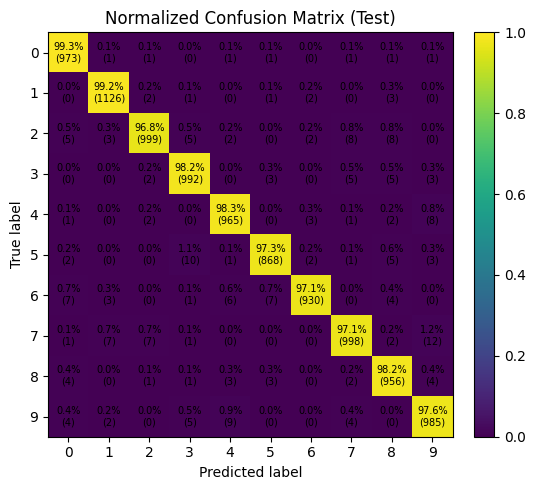

Per-class accuracy: [0.9929 0.9921 0.968  0.9822 0.9827 0.9731 0.9708 0.9708 0.9815 0.9762]
Overall accuracy: 0.9792


In [ ]:
#@title Confusion Matrix on the Test Set (Normalized)
import numpy as np
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def compute_confusion_matrix(model, loader, device, num_classes=10, normalize=True, eps=1e-12):
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        pred = model(data).argmax(dim=1)
        for t, p in zip(target.view(-1), pred.view(-1)):
            cm[int(t.item()), int(p.item())] += 1
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_norm = cm / np.maximum(row_sums, eps)
        return cm, cm_norm
    else:
        return cm, None

model.load_state_dict(torch.load("best_mnist_val_fc.pt", map_location=device))
cm_raw, cm_norm = compute_confusion_matrix(model, test_loader, device, num_classes=10, normalize=True)

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, vmin=0.0, vmax=1.0, interpolation='nearest')
ax.set_title('Normalized Confusion Matrix (Test)')
ax.set_xlabel('Predicted label'); ax.set_ylabel('True label')
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xticklabels(range(10)); ax.set_yticklabels(range(10))
for i in range(10):
    for j in range(10):
        ax.text(j, i, f"{cm_norm[i, j]*100:.1f}%\n({cm_raw[i, j]})",
                ha='center', va='center', fontsize=7)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

per_class_acc = np.diag(cm_norm)
overall_acc = np.trace(cm_raw) / cm_raw.sum()
print("Per-class accuracy:", np.round(per_class_acc, 4))
print("Overall accuracy:", round(overall_acc, 4))


Collected 208 misclassified samples.


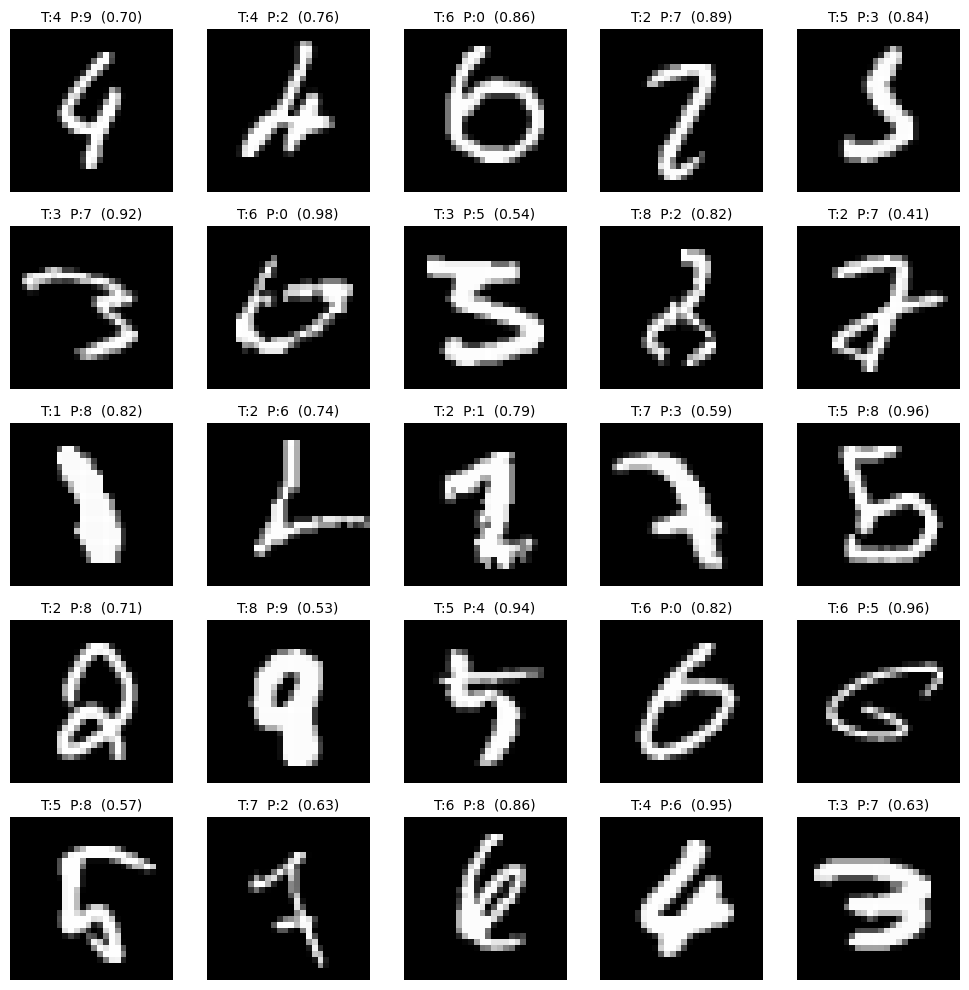

In [ ]:
#@title Collect and visualize misclassified test samples
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

@torch.no_grad()
def collect_misclassified(model, loader, device):
    model.eval()
    mis = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        wrong = preds.ne(y)
        if wrong.any():
            idxs = torch.nonzero(wrong, as_tuple=False).squeeze(1)
            for i in idxs:
                mis.append({
                    "img": x[i].detach().cpu(),
                    "true": int(y[i].item()),
                    "pred": int(preds[i].item()),
                    "pred_conf": float(probs[i, preds[i]].item()),
                    "true_conf": float(probs[i, y[i]].item())
                })
    return mis

def denorm_mnist(t):
    t = t.clone()
    t = t * 0.3081 + 0.1307
    return t

def show_misclassified(mis, n=25, cols=5):
    if len(mis) == 0:
        print("No misclassified samples.")
        return
    n = min(n, len(mis))
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        m = mis[i]
        img = denorm_mnist(m["img"]).squeeze(0).numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{m['true']}  P:{m['pred']}  ({m['pred_conf']:.2f})", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_misclassified_per_class(mis, k=5):
    buckets = defaultdict(list)
    for m in mis:
        buckets[m["true"]].append(m)
    rows, cols = 10, k
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for true_label in range(10):
        items = buckets[true_label][:k]
        for j in range(cols):
            plt.subplot(rows, cols, idx); idx += 1
            if j < len(items):
                m = items[j]
                img = denorm_mnist(m["img"]).squeeze(0).numpy()
                plt.imshow(img, cmap="gray")
                plt.title(f"T:{true_label}→P:{m['pred']}", fontsize=8)
                plt.axis("off")
            else:
                plt.axis("off")
    plt.suptitle("Misclassified per TRUE class (rows 0..9)", y=0.92)
    plt.tight_layout()
    plt.show()

def show_hardest_errors(mis, n=25, by="margin"):
    if len(mis) == 0:
        print("No misclassified samples.")
        return
    if by == "margin":
        ranked = sorted(mis, key=lambda m: m["pred_conf"] - m["true_conf"], reverse=True)
    elif by == "low_true":
        ranked = sorted(mis, key=lambda m: m["true_conf"])
    else:
        ranked = mis
    show_misclassified(ranked, n=n, cols=5)

model.load_state_dict(torch.load("best_mnist_val_fc.pt", map_location=device))
misclassified = collect_misclassified(model, test_loader, device)
print(f"Collected {len(misclassified)} misclassified samples.")
show_misclassified(misclassified, n=25, cols=5)
# show_misclassified_per_class(misclassified, k=5)
# show_hardest_errors(misclassified, n=20, by="margin")


<IPython.core.display.Javascript object>

Predicted digit: 2


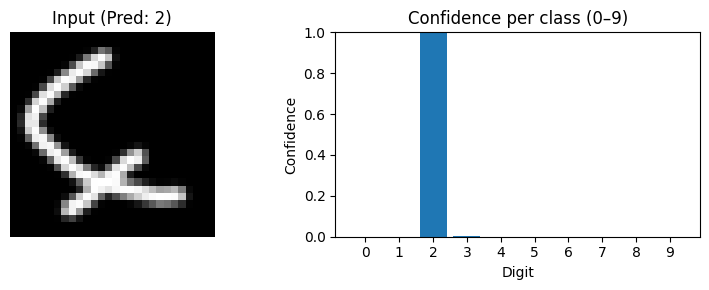

In [ ]:
#@title Draw a digit (0–9) and classify with the trained MLP (with confidence chart)
from google.colab.output import eval_js
from IPython.display import display, Javascript
from base64 import b64decode
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()
try:
    model.load_state_dict(torch.load("best_mnist_val_fc.pt", map_location=device))
except Exception as e:
    print("Warning: could not load best_mnist_val_fc.pt. Train the model first.", e)

js = Javascript('''
async function draw_digit() {
  return await new Promise((resolve) => {
    const div = document.createElement('div');
    div.style.margin = '8px 0';
    const title = document.createElement('div');
    title.textContent = 'Draw a digit (white on black). Click Predict.';
    title.style.margin = '6px 0';
    const canvas = document.createElement('canvas');
    canvas.width = 280; canvas.height = 280;
    canvas.style.border = '1px solid #999';
    canvas.style.touchAction = 'none';
    const ctx = canvas.getContext('2d');
    ctx.fillStyle = 'black'; ctx.fillRect(0,0,canvas.width,canvas.height);
    let drawing=false;
    function rel(e){const r=canvas.getBoundingClientRect(); return {x:e.clientX-r.left, y:e.clientY-r.top};}
    canvas.addEventListener('mousedown', e=>{drawing=true; const p=rel(e); ctx.lineWidth=20; ctx.lineCap='round'; ctx.strokeStyle='white'; ctx.beginPath(); ctx.moveTo(p.x,p.y);});
    canvas.addEventListener('mousemove', e=>{if(!drawing)return; const p=rel(e); ctx.lineTo(p.x,p.y); ctx.stroke();});
    canvas.addEventListener('mouseup', ()=>{drawing=false;});
    canvas.addEventListener('mouseleave', ()=>{drawing=false;});
    canvas.addEventListener('touchstart', e=>{const r=canvas.getBoundingClientRect(); const t=e.touches[0]; drawing=true; ctx.lineWidth=20; ctx.lineCap='round'; ctx.strokeStyle='white'; ctx.beginPath(); ctx.moveTo(t.clientX-r.left,t.clientY-r.top); e.preventDefault();},{passive:false});
    canvas.addEventListener('touchmove', e=>{if(!drawing)return; const r=canvas.getBoundingClientRect(); const t=e.touches[0]; ctx.lineTo(t.clientX-r.left,t.clientY-r.top); ctx.stroke(); e.preventDefault();},{passive:false});
    canvas.addEventListener('touchend', ()=>{drawing=false;},{passive:false});
    const btns=document.createElement('div'); btns.style.marginTop='6px';
    const clearBtn=document.createElement('button'); clearBtn.textContent='Clear';
    const predictBtn=document.createElement('button'); predictBtn.textContent='Predict';
    clearBtn.style.marginRight='6px';
    clearBtn.onclick=()=>{ctx.fillStyle='black'; ctx.fillRect(0,0,canvas.width,canvas.height);};
    predictBtn.onclick=()=>{const dataURL=canvas.toDataURL('image/png'); resolve(dataURL); document.body.removeChild(div);};
    btns.appendChild(clearBtn); btns.appendChild(predictBtn);
    div.appendChild(title); div.appendChild(canvas); div.appendChild(btns);
    document.body.appendChild(div);
  });
}
''')
display(js)
dataURL = eval_js('draw_digit()')

if dataURL.startswith('data:image/png;base64,'):
    b64 = dataURL.split(',')[1]
else:
    b64 = dataURL

import io
img = Image.open(io.BytesIO(b64decode(b64))).convert('L')
img_small = img.resize((28,28), Image.BILINEAR)
arr = np.array(img_small).astype(np.float32)/255.0
x = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0)
x = (x - 0.1307) / 0.3081
x = x.to(device)

with torch.no_grad():
    out = model(x)
    probs = torch.softmax(out, dim=1).cpu().numpy().squeeze(0)  # normalized 0–1
    pred = int(np.argmax(probs))

print(f"Predicted digit: {pred}")

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].imshow(arr, cmap='gray')
axs[0].set_title(f'Input (Pred: {pred})')
axs[0].axis('off')
axs[1].bar(range(10), probs)
axs[1].set_xticks(range(10))
axs[1].set_ylim([0, 1])
axs[1].set_xlabel("Digit")
axs[1].set_ylabel("Confidence")
axs[1].set_title("Confidence per class (0–9)")
plt.tight_layout()
plt.show()
